# Testing

In [1]:
import sys, os
import torch
sys.path.append("../../")
sys.path.append("../../../")
sys.path.append("../../../../")

from sklearn.metrics import classification_report
from Clust.clust.transformation.type.DFToNPArray import transDFtoNP, trans_df_to_np, trans_df_to_np_inf
from Clust.clust.ML.tool import data as ml_data
from Clust.clust.ML.tool import scaler as ml_scaler
from Clust.clust.ML.tool import clean as ml_clean

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient

db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

#import main_regression as mr
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda is available.


## Test Data Preparation

In [2]:
# get integrated data name
bucket_name = 'integration'

# scaler path
scalerPath = './scaler/'

In [3]:
db_name = 'model'
collection_name = 'meta'

search = {'modelName': 'classification_actionPattern_LSTM_cf_cleanLevel0'}

model_meta= mongo_client.get_document_by_json(db_name, collection_name, search)[0]
model_meta

{'modelName': 'classification_actionPattern_LSTM_cf_cleanLevel0',
 'trainDataInfo': {'data_name': 'classification_actionPattern_trainX_cleanLevel0',
  'ingestion_param': {'start_time': '1992-1-11',
   'end_time': '2012-02-27',
   'ms_list_info': [['bio_action_sensors', 'accelerationTrain']]},
  'integration_param': {'param': {},
   'method': 'meta',
   'integration_duration': 'common',
   'integration_frequency': 675},
  'clean_level': 0,
  'process_param': {'refine_param': {'removeDuplication': {'flag': False},
    'staticFrequency': {'flag': False, 'frequency': None}},
   'outlier_param': {'certainErrorToNaN': {'flag': False},
    'unCertainErrorToNaN': {'flag': False}},
   'imputation_param': {'flag': False}}},
 'featureList': ['col_0',
  'col_1',
  'col_2',
  'col_3',
  'col_4',
  'col_5',
  'col_6',
  'col_7',
  'col_8'],
 'target': ['value'],
 'trainDataType': 'timeseries',
 'modelPurpose': 'classification',
 'model_method': 'LSTM_cf',
 'modelTags': ['action', 'sensor', 'classifi

In [4]:
collection_list = mongo_client.get_collection_list(bucket_name)
collection_list

['forecasting_strawberryOpen',
 'regression_energy',
 'forecasting_Hs2SwineFarmWithWeatherTime',
 'forecasting_gunwiStrawberryWeather',
 'classification_actionPattern']

In [5]:
# 1. Select Test Data
data_name_X = 'classification_actionPattern_testX_cleanLevel0'
dataX = db_client.get_data(bucket_name, data_name_X)

data_name_y = 'classification_actionPattern_testy_cleanLevel0'
datay = db_client.get_data(bucket_name, data_name_y)

clean_level = model_meta["trainDataInfo"]["clean_level"]
integration_freq_sec = model_meta["trainDataInfo"]["integration_param"]["integration_frequency"]

window_num=128

## Testing

In [6]:
feature_list = model_meta["featureList"]
target = model_meta["target"]
model_method = model_meta["model_method"]
scaler_param = model_meta["scalerParam"]
model_file_path = model_meta['files']['modelFile']["filePath"]

X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]


dim = None
if model_method == "FC_cf":
    dim = 2

test_X, scaler_X = ml_scaler.get_scaled_test_data(dataX[feature_list], X_scaler_file_path, scaler_param)
test_y, scaler_y = ml_scaler.get_scaled_test_data(datay[target], y_scaler_file_path, scaler_param)# No Scale

test_X, test_y = trans_df_to_np(test_X, test_y, window_num, dim)

In [7]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': device,
    'batch_size': 1,
    'scaler_param' : 'noScale'
}

In [8]:
from Clust.clust.ML.classification.test import ClassificationTest as CT

ct = CT()
ct.set_param(testParameter)
ct.set_model(model_method, model_file_path, modelParameter)
ct.set_data(test_X, test_y)
preds, probs, trues, acc = ct.test()

/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Start testing data

** Performance of test dataset ==> PROB = [[0.27221224 0.14693156 0.20503466 0.03351972 0.3411454  0.00115647]
 [0.25972977 0.1287405  0.20829622 0.04112133 0.3608106  0.00130157]
 [0.23107077 0.43879282 0.19649522 0.00971253 0.12218859 0.00174   ]
 ...
 [0.27264982 0.1513896  0.2022552  0.03240357 0.3402574  0.00104439]
 [0.18764034 0.06324291 0.14058961 0.22844113 0.37672803 0.00335801]
 [0.2860485  0.17173684 0.20145312 0.03245208 0.30693388 0.0013756 ]], ACC = 0.4382671480144404
** Dimension of result for test dataset = (1385,)


In [9]:
print(test_X.shape, test_y.shape)
print(preds.shape, probs.shape)

(1385, 9, 128) (1385,)
(1385,) (1385, 6)


In [10]:
result_metrics = classification_report(trues, preds, output_dict = True)
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler_y, feature_list= target, target_col = target[0])

noscale


/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/programdrive/anaconda3/envs/clust/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{0, 1, 3, 4, 5}

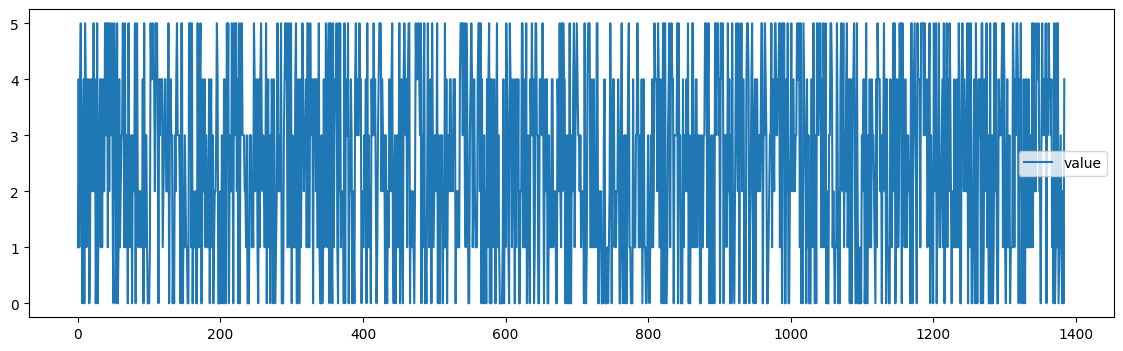

In [11]:
df_result[['value']].plot()
set(df_result['prediction'].values)

In [14]:
df_result

,value,prediction
0,1,4
1,4,4
2,1,1
3,4,4
4,5,3
...,...,...
1380,1,1
1381,0,1
1382,2,4
1383,0,4


In [12]:
result_metrics

{'0': {'precision': 0.3007518796992481,
  'recall': 0.1593625498007968,
  'f1-score': 0.20833333333333334,
  'support': 251},
 '1': {'precision': 0.36904761904761907,
  'recall': 0.4170403587443946,
  'f1-score': 0.3915789473684211,
  'support': 223},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 197},
 '3': {'precision': 0.5035971223021583,
  'recall': 0.6140350877192983,
  'f1-score': 0.5533596837944663,
  'support': 228},
 '4': {'precision': 0.26515151515151514,
  'recall': 0.5622489959839357,
  'f1-score': 0.36036036036036034,
  'support': 249},
 '5': {'precision': 1.0,
  'recall': 0.8185654008438819,
  'f1-score': 0.9002320185614849,
  'support': 237},
 'accuracy': 0.43826714801444044,
 'macro avg': {'precision': 0.40642468936675674,
  'recall': 0.4285420655153846,
  'f1-score': 0.402310723903011,
  'support': 1385},
 'weighted avg': {'precision': 0.41561675957382643,
  'recall': 0.43826714801444044,
  'f1-score': 0.4107324895045231,
  'support': 1385}}

In [13]:
acc

0.4382671480144404